# Baseline Models

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, RocCurveDisplay, roc_curve
from sklearn import metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [130]:
data = pd.read_csv('../data/data.csv')

In [131]:
# Drop irrelevant columns
y = data['bank_status']
X = data.drop(columns = ['cik', 'sic', 'sic_description', 'filedate', 'accession_num',
       'primary_doc', 'filelink', 'bank_status'])

In [132]:
# Create dummy variables for industry and year
X_with_dummies = pd.get_dummies(X, columns = ['main_industry', 'year'])

In [133]:
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_with_dummies, y, test_size = 0.25, random_state = 42)

In [134]:
# Standardization
scaler = StandardScaler().fit(X_train.iloc[:, 0:23])
scaled_terms_train = pd.DataFrame(scaler.transform(X_train.iloc[:, 0:23]), columns = X_train.columns[0:23])
X_train_scaled = pd.concat([scaled_terms_train, X_train.iloc[:,23:].reset_index(drop = True)], axis = 1)
scaled_terms_test = pd.DataFrame(scaler.transform(X_test.iloc[:, 0:23]), columns = X_test.columns[0:23])
X_test_scaled = pd.concat([scaled_terms_test, X_test.iloc[:,23:].reset_index(drop = True)], axis = 1)

In [135]:
def measure(clf):
    y_pred_test = clf.predict(X_test_scaled)
    y_pred_prob_test = clf.predict_proba(X_test_scaled)[:,1]
    y_pred_train = clf.predict(X_train_scaled)
    y_pred_prob_train = clf.predict_proba(X_train_scaled)[:,1]

    print(classification_report(y_train, y_pred_train))
    print("Train Auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
    print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

    print(classification_report(y_test, y_pred_test))
    print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
    print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))

## Logistic Regression

In [136]:
lr = LogisticRegression(max_iter = 1000, fit_intercept = False, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
measure(lr)

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9587
           1       0.03      0.93      0.05        46

    accuracy                           0.84      9633
   macro avg       0.51      0.89      0.48      9633
weighted avg       0.99      0.84      0.91      9633

Train Auc_roc: 0.9256511308338737
Train average precision: 0.042002700630339944
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3186
           1       0.04      0.77      0.07        26

    accuracy                           0.83      3212
   macro avg       0.52      0.80      0.49      3212
weighted avg       0.99      0.83      0.90      3212

Test auc_roc: 0.9260888985465258
Test average precision: 0.11535793169322835


In [137]:
# The coefficients for each feature
df = pd.DataFrame({
    'Features': X_train_scaled.columns,
    'Coefficients': lr.coef_[0]
}
).sort_values(by = 'Coefficients')
print(df)

                                             Features  Coefficients
13                                      current_ratio     -7.072905
25   main_industry_Finance, Insurance and Real Estate     -4.999263
24                         main_industry_Construction     -3.526908
23    main_industry_Agriculture, Forestry and Fishing     -3.065323
33                                          year_2011     -3.038593
12                            CommonStockSharesIssued     -2.735804
29                             main_industry_Services     -2.534938
37                                          year_2015     -2.366306
44                                          year_2022     -2.063071
26                        main_industry_Manufacturing     -2.010231
1                                       AssetsCurrent     -1.938121
6          NetCashProvidedByUsedInOperatingActivities     -1.922352
39                                          year_2017     -1.866938
40                                          year

## Decision Tree

In [138]:
parameters = {
    'max_depth': [10, 15, 20, 25, 30], 
    'min_samples_leaf': [5, 10, 20, 30], 
    'max_features': ['sqrt', 'log2'], 
    'ccp_alpha': [0.01, 0.001, 0.0001, 0.00001]
}
grid_search = GridSearchCV(
            estimator = tree.DecisionTreeClassifier(class_weight = 'balanced', random_state = 42),
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'ccp_alpha': 0.001, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 10}
Best score: 0.08495030556368036


In [139]:
measure(grid_search)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9587
           1       0.20      1.00      0.33        46

    accuracy                           0.98      9633
   macro avg       0.60      0.99      0.66      9633
weighted avg       1.00      0.98      0.99      9633

Train Auc_roc: 0.9922029832064254
Train average precision: 0.26861488547273465
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3186
           1       0.14      0.35      0.20        26

    accuracy                           0.98      3212
   macro avg       0.57      0.66      0.59      3212
weighted avg       0.99      0.98      0.98      3212

Test auc_roc: 0.6647834274952922
Test average precision: 0.07128455538693462


## SVM

In [140]:
param_grid_reduced = {
    'C': [10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf'] 
}

svm_balanced = SVC(class_weight = 'balanced', random_state = 42, probability=True)
grid_search_reduced = GridSearchCV(svm_balanced, param_grid_reduced, scoring = 'average_precision', cv = 5)

# Fit the grid search
grid_search_reduced.fit(X_train_scaled, y_train)

# Output the best parameters and the best score
print("Best parameters:", grid_search_reduced.best_params_)
print("Best score:", grid_search_reduced.best_score_)

Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.12829589340262632


In [141]:
measure(grid_search_reduced)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9587
           1       0.27      1.00      0.42        46

    accuracy                           0.99      9633
   macro avg       0.63      0.99      0.71      9633
weighted avg       1.00      0.99      0.99      9633

Train Auc_roc: 0.9967256384324787
Train average precision: 0.41720968325330565
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3186
           1       0.19      0.50      0.27        26

    accuracy                           0.98      3212
   macro avg       0.59      0.74      0.63      3212
weighted avg       0.99      0.98      0.98      3212

Test auc_roc: 0.9307849244289922
Test average precision: 0.28006059244714393


## SMOTE + Decision Tree

In [142]:
model = DecisionTreeClassifier(random_state = 42)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)

parameters = {
    'model__max_depth': [5, 10, 15], 
    'model__min_samples_leaf': [40, 50, 60], 
    'model__max_features': ['log2'], 
    'model__ccp_alpha': [0.0001, 0.00001, 0.000001]
}
smote_tree = GridSearchCV(
            pipeline,
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
smote_tree.fit(X_train_scaled, y_train)
print("Best parameters:", smote_tree.best_params_)
print("Best score:", smote_tree.best_score_)

Best parameters: {'model__ccp_alpha': 1e-05, 'model__max_depth': 10, 'model__max_features': 'log2', 'model__min_samples_leaf': 50}
Best score: 0.10684436549915599


In [143]:
measure(smote_tree)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9587
           1       0.06      0.87      0.11        46

    accuracy                           0.93      9633
   macro avg       0.53      0.90      0.54      9633
weighted avg       0.99      0.93      0.96      9633

Train Auc_roc: 0.9718992204116987
Train average precision: 0.19833537188387634
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      3186
           1       0.08      0.81      0.15        26

    accuracy                           0.92      3212
   macro avg       0.54      0.87      0.55      3212
weighted avg       0.99      0.92      0.95      3212

Test auc_roc: 0.9271089864310204
Test average precision: 0.177545783076817


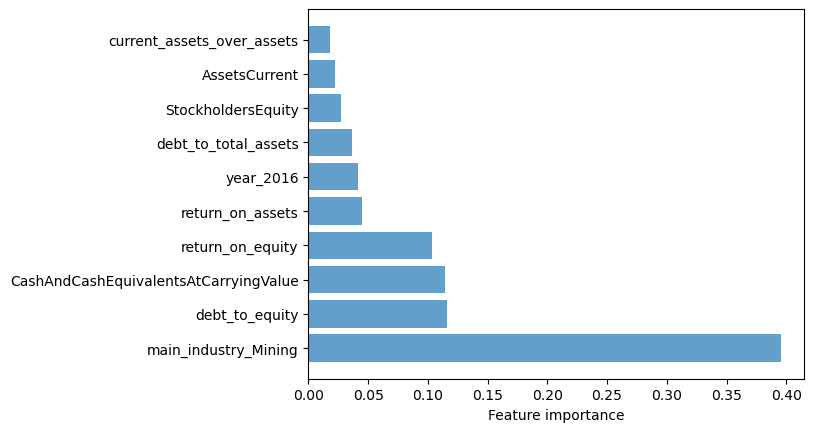

In [144]:
importances = smote_tree.best_estimator_.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.barh(range(len(indices)), importances[indices], alpha = 0.7)
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.xlabel("Feature importance")
plt.show()

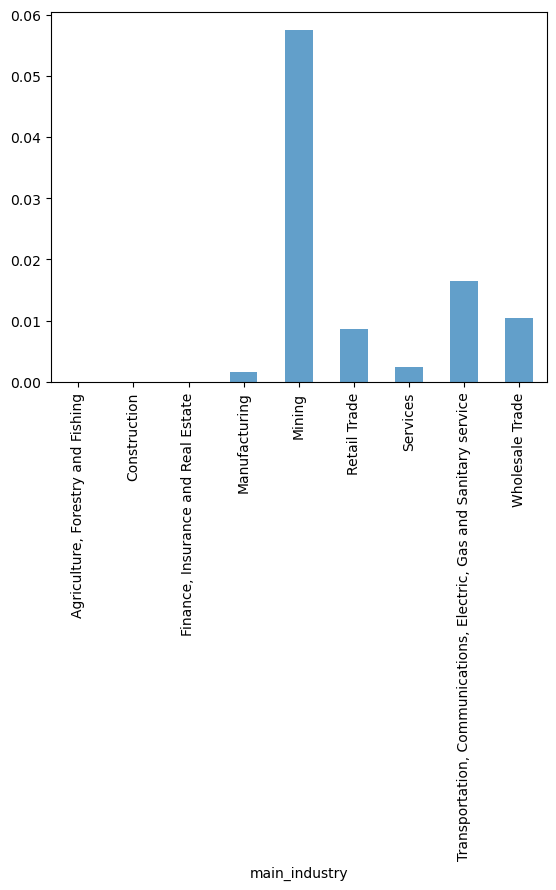

In [145]:
# Mining industry has the highest bankruptcy ratio
num_bank = data.groupby('main_industry')['bank_status'].apply(lambda x: (x == 1).sum())
num_nonbank = data.groupby('main_industry')['bank_status'].apply(lambda x: (x == 0).sum())
ratio = num_bank / num_nonbank
ratio.plot(kind = "bar", alpha = 0.7)
plt.xticks(rotation = 90)
plt.show()

## SMOTE + Logistic Regression

In [146]:
model = LogisticRegression(max_iter = 1000, fit_intercept = False)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
smote_lr = Pipeline(steps = steps)
smote_lr.fit(X_train_scaled, y_train)

Pipeline(steps=[('over', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.9)),
                ('model',
                 LogisticRegression(fit_intercept=False, max_iter=1000))])

In [147]:
measure(smote_lr)

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9587
           1       0.02      0.83      0.05        46

    accuracy                           0.84      9633
   macro avg       0.51      0.83      0.48      9633
weighted avg       0.99      0.84      0.91      9633

Train Auc_roc: 0.913349599321545
Train average precision: 0.039931866095125154
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3186
           1       0.04      0.81      0.07        26

    accuracy                           0.83      3212
   macro avg       0.52      0.82      0.49      3212
weighted avg       0.99      0.83      0.90      3212

Test auc_roc: 0.9262216910521995
Test average precision: 0.12074872941461902


In [148]:
# The coefficients for each feature
df = pd.DataFrame({
    'Features': X_train_scaled.columns,
    'Coefficients': smote_lr.named_steps['model'].coef_[0]
}
).sort_values(by = 'Coefficients')
print(df[df['Coefficients']>0]['Features'].tolist())

['NetCashProvidedByUsedInFinancingActivities', 'year_2015', 'ebit_over_assets', 'cash_operation_over_liabilities', 'OperatingIncomeLoss', 'year_2021', 'NetIncomeLoss', 'CashAndCashEquivalentsAtCarryingValue', 'year_2012', 'year_2014', 'year_2013', 'year_2020', 'LiabilitiesCurrent', 'year_2024', 'Assets', 'main_industry_Mining', 'year_2016']


## SMOTE + SVM

In [ ]:
model = SVC(probability=True, random_state = 42)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)

parameters = {
    'model__C': [10, 100, 1000],
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['rbf'] 
}
smote_svm = GridSearchCV(
            pipeline,
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
smote_svm.fit(X_train_scaled, y_train)
print("Best parameters:", smote_svm.best_params_)
print("Best score:", smote_svm.best_score_)

In [ ]:
measure(smote_svm)